# Wiener Filter + UNet

https://github.com/vpronina/DeepWienerRestoration

In [10]:
# Import some libraries

import numpy as np
from skimage import color, data, restoration
import matplotlib.pyplot as plt
import torch
import utils
import torch.nn as nn
from networks import UNet
import math
import os
from skimage import io
import skimage
import warnings
warnings.filterwarnings('ignore')

In [11]:
def show_images(im1, im1_title, im2, im2_title, im3, im3_title, font):
    fig, (image1, image2, image3) = plt.subplots(1, 3, figsize=(15, 50))
    image1.imshow(im1, cmap='gray')
    image1.set_title(im1_title, fontsize=font)
    image1.set_axis_off()
    image2.imshow(im2, cmap='gray')
    image2.set_title(im2_title, fontsize=font)
    image2.set_axis_off()
    image3.imshow(im3, cmap='gray')
    image3.set_title(im3_title, fontsize=font)
    image3.set_axis_off()
    fig.subplots_adjust(wspace=0.02, hspace=0.2,
                                top=0.9, bottom=0.05, left=0, right=1)
    fig.show()

# Load the data

In [12]:
#Load the target image
image = io.imread('./image.tif')

#Load the blurred and distorted images
blurred = io.imread('./blurred.tif')
distorted = io.imread('./distorted.tif')

#Load the kernel
psf = io.imread('./PSF.tif')

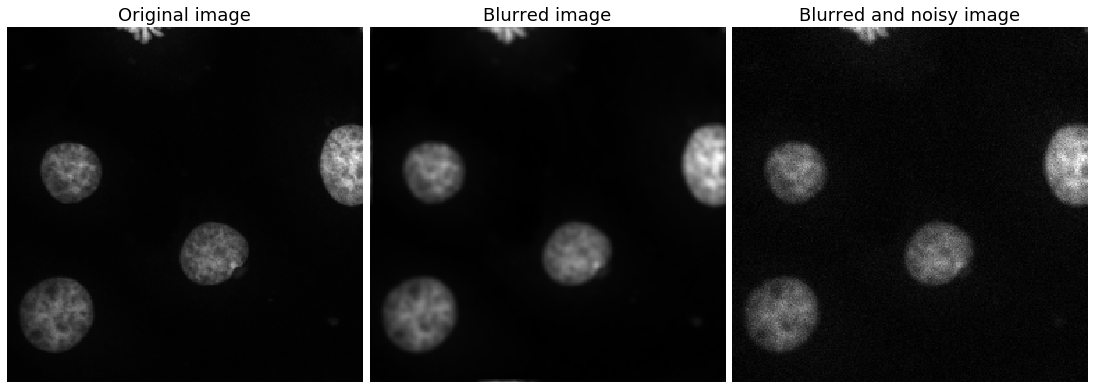

In [13]:
show_images(image, 'Original image', blurred, 'Blurred image',\
           distorted, 'Blurred and noisy image', font=18)

We know, that the solution is described as follows:

$\hat{\mathbf{x}} = \arg\min_\mathbf{x}\underbrace{\frac{1}{2}\|\mathbf{y}-\mathbf{K} \mathbf{x}\|_{2}^{2}+\lambda r(\mathbf{x})}_{\mathbf{J}(\mathbf{x})}$,
where $\mathbf{J}$ is the objective function.

According to the gradient descent iterative scheme,

$\hat{\mathbf{x}}_{k+1}=\hat{\mathbf{x}}_{k}-\beta \nabla \mathbf{J}(\mathbf{x})$.

Solution is described with the iterative gradient descent equation:

$\hat{\mathbf{x}}_{k+1} = \hat{\mathbf{x}}_{k} - \beta\left[\mathbf{K}^\top(\mathbf{K}\hat{\mathbf{x}}_{k} - \mathbf{y}) + e^\alpha f^{CNN}(\hat{\mathbf{x}}_{k})\right]$, and here $\lambda = e^\alpha$ and $r(\mathbf{x}) = f^{CNN}(\hat{\mathbf{x}})$.

In [14]:
# Anscombe transform to transform Poissonian data into Gaussian
#https://en.wikipedia.org/wiki/Anscombe_transform

def anscombe(x):
    '''
    Compute the anscombe variance stabilizing transform.
      the input   x   is noisy Poisson-distributed data
      the output  fx  has variance approximately equal to 1.
    Reference: Anscombe, F. J. (1948), "The transformation of Poisson,
    binomial and negative-binomial data", Biometrika 35 (3-4): 246-254
    '''
    return 2.0*torch.sqrt(x + 3.0/8.0)

# Exact unbiased Anscombe transform to transform Gaussian data back into Poissonian
def exact_unbiased(z):
    return (1.0 / 4.0 * z.pow(2) +
            (1.0/4.0) * math.sqrt(3.0/2.0) * z.pow(-1) -
            (11.0/8.0) * z.pow(-2) +
            (5.0/8.0) * math.sqrt(3.0/2.0) * z.pow(-3) - (1.0 / 8.0))

class WienerUNet(torch.nn.Module):

    def __init__(self):
        '''
        Deconvolution function for a batch of images. Although the regularization
        term does not have a shape of Tikhonov regularizer, with a slight abuse of notations
        the function is called WienerUNet.

        The function is built upon the iterative gradient descent scheme:

        x_k+1 = x_k - lamb[K^T(Kx_k - y) + exp(alpha)*reg(x_k)]

        Initial parameters are:
        regularizer: a neural network to parametrize the prior on each iteration x_k.
        alpha: power of the trade-off coefficient.
        lamb: step of the gradient descent algorithm.
        '''
        super(WienerUNet, self).__init__()
        self.regularizer = UNet(mode='instance')
        self.alpha = nn.Parameter(torch.FloatTensor([0.0]))
        self.lamb = nn.Parameter(torch.FloatTensor([0.3]))

    def forward(self, x, y, ker):
        '''
        Function that performs one iteration of the gradient descent scheme of the deconvolution algorithm.

        :param x: (torch.(cuda.)Tensor) Image, restored with the previous iteration of the gradient descent scheme, B x C x H x W
        :param y: (torch.(cuda.)Tensor) Input blurred and noisy image, B x C x H x W
        :param ker: (torch.(cuda.)Tensor) Blurring kernel, B x C x H_k x W_k
        :return: (torch.(cuda.)Tensor) Restored image, B x C x H x W
        '''
        
        #Calculate Kx_k
        x_filtered = utils.imfilter2D_SpatialDomain(x, ker, padType='symmetric', mode="conv")
        Kx_y = x_filtered - y

        #Calculate K^T(Kx_k - y)
        y_filtered = utils.imfilter_transpose2D_SpatialDomain(Kx_y, ker,
                                                              padType='symmetric', mode="conv")
        
        #Calculate exp(alpha)*reg(x_k)
        regul = torch.exp(self.alpha) * self.regularizer(x)

        brackets = y_filtered + regul
        out = x - self.lamb * brackets

        return out
    
class WienerFilter_UNet(nn.Module):
    '''
    Module that uses UNet to predict individual gradient of a regularizer for each input image and then
    applies gradient descent scheme with predicted gradient of a regularizers per-image.
    '''
    def __init__(self):

        super(WienerFilter_UNet, self).__init__()
        self.function = WienerUNet()
    
    #Perform gradient descent iterations
    def forward(self, y, ker, n_iter):
        output = y.clone()

        for i in range(n_iter):
            output = self.function(output, y, ker)

        return output

In [15]:
#Let's transform our numpy data into pytorch data
x = torch.Tensor(distorted[None, None])
ker = torch.Tensor(psf[None, None])

#Define the model
model = WienerFilter_UNet()

#Load the pretrained weights
state_dict = torch.load(os.path.join('./', 'WF_UNet_poisson'))
state_dict = state_dict['model_state_dict']
from collections import OrderedDict
new_state_dict = OrderedDict()
for k, v in state_dict.items():
    name = k[7:]  # remove `module.`
    new_state_dict[name] = v
# load params
model.load_state_dict(new_state_dict)
model.eval()

WienerFilter_UNet(
  (function): WienerUNet(
    (regularizer): UNet(
      (inc): inconv(
        (conv): double_conv(
          (conv): Sequential(
            (0): Conv2d(1, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (1): InstanceNorm2d(12, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
            (2): ReLU(inplace=True)
            (3): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (4): InstanceNorm2d(12, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
            (5): ReLU(inplace=True)
          )
        )
      )
      (down1): down(
        (mpconv): Sequential(
          (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
          (1): double_conv(
            (conv): Sequential(
              (0): Conv2d(12, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
              (1): InstanceNorm2d(24, eps=1e-05, momentum=0.1, affine=False, track_running_st

In [16]:
#Perform Anscombe transform
x = anscombe(x)

#Calculate output
out = model(x, ker, 10)

#Perform inverse Anscombe transform
out = exact_unbiased(out)

#Some post-processing of data
out = out/image.max()
image = image/image.max()

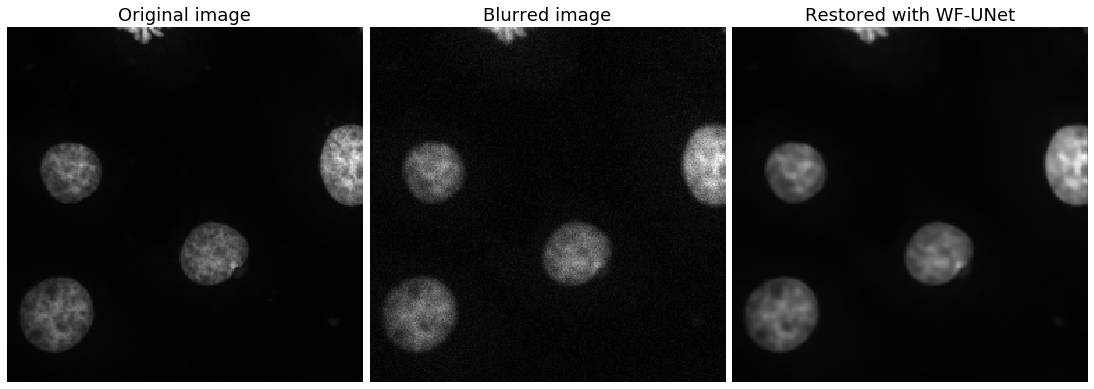

In [17]:
show_images(image, 'Original image', distorted, 'Blurred image',\
           out[0][0].detach().cpu().numpy().clip(0,1), 'Restored with WF-UNet', font=18)